In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [4]:
Friday_WorkingHours_Afternoon_DDos            = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
Friday_WorkingHours_Afternoon_PortScan        = pd.read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
Friday_WorkingHours_Morning                   = pd.read_csv("Friday-WorkingHours-Morning.pcap_ISCX.csv")
Monday_WorkingHours                           = pd.read_csv("Monday-WorkingHours.pcap_ISCX.csv")
Thursday_WorkingHours_Afternoon_Infilteration = pd.read_csv("Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
Thursday_WorkingHours_Morning_WebAttacks      = pd.read_csv("Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
Tuesday_WorkingHours                          = pd.read_csv("Tuesday-WorkingHours.pcap_ISCX.csv")
Wednesday_workingHours                        = pd.read_csv("Wednesday-workingHours.pcap_ISCX.csv")

In [8]:
df = pd.concat(
    [
        Friday_WorkingHours_Afternoon_DDos,
        Friday_WorkingHours_Afternoon_PortScan,
        Friday_WorkingHours_Morning,
        Monday_WorkingHours,
        Thursday_WorkingHours_Afternoon_Infilteration,
        Thursday_WorkingHours_Morning_WebAttacks,
        Tuesday_WorkingHours,
        Wednesday_workingHours
    ],
    axis=0
)
df.columns = Friday_WorkingHours_Afternoon_DDos.columns

In [9]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [11]:
# Drop non-numeric columns if any
df_numeric = df.select_dtypes(include=[float, int])

# Handle missing values (e.g., replacing NaN with the mean of the column)
df_numeric.fillna(df_numeric.mean(), inplace=True)

In [12]:
# Check for infinity values and replace them with NaN
df_numeric.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Check for NaN values and replace them with the column mean (or other strategy)
df_numeric.fillna(df_numeric.mean(), inplace=True)

# Optionally, you can check for extreme values and cap them if needed:
# For example, if you want to cap the values to a certain threshold
df_numeric = df_numeric.clip(-1e6, 1e6)  # Adjust the threshold as necessary

In [13]:
if df_numeric.isna().sum().sum() > 0:
    print("There are still missing values!")
if (df_numeric == float('inf')).sum().sum() > 0:
    print("There are still infinity values!")

# Ensure all values are finite
assert not df_numeric.isna().values.any(), "There are NaN values!"
assert not (df_numeric == float('inf')).values.any(), "There are infinity values!"

In [14]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

In [15]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

In [16]:
kmeans = KMeans(n_clusters=2, random_state=42)  # You can adjust n_clusters
kmeans.fit(df_pca)

C:\Users\Arsh Chadha\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

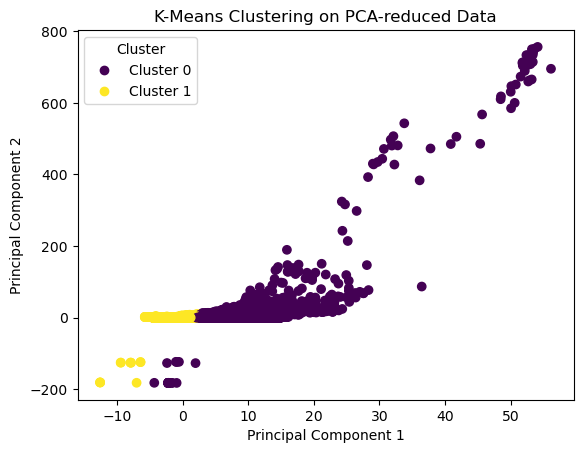

In [19]:
# Add cluster labels to the DataFrame
df['Cluster'] = kmeans.labels_

scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('K-Means Clustering on PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend to show which color corresponds to which cluster
plt.legend(handles=scatter.legend_elements()[0], labels=['Cluster 0', 'Cluster 1'], title='Cluster')
plt.show()

In [30]:
anomalies = df[df['Cluster'] == 1]  
print("Anomalies Detected:")
print(anomalies)

Anomalies Detected:
         Destination Port   Flow Duration   Total Fwd Packets  \
0                   54865               3                   2   
1                   55054             109                   1   
2                   55055              52                   1   
3                   46236              34                   1   
4                   54863               3                   2   
...                   ...             ...                 ...   
692698                 53           32215                   4   
692699                 53             324                   2   
692700              58030              82                   2   
692701                 53         1048635                   6   
692702                 53           94939                   4   

         Total Backward Packets  Total Length of Fwd Packets  \
0                             0                           12   
1                             1                            6   
2      

In [31]:
sil_score = silhouette_score(df_pca, df['Cluster'])
print(f"Silhouette Score: {sil_score}")

KeyboardInterrupt: 